# Imports

In [1]:
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchvision
import torchmetrics
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Loading the MNIST dataset

In [2]:
train_mnist = torchvision.datasets.MNIST('data/mnist', train=True, download=True, transform=torchvision.transforms.ToTensor())
small_train_mnist = torch.utils.data.Subset(train_mnist, np.random.randint(0, len(train_mnist), 10000))
test_mnist = torchvision.datasets.MNIST('data/mnist', train=False, download=True, transform=torchvision.transforms.ToTensor())
train_mnist, test_mnist

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data/mnist
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data/mnist
     Split: Test
     StandardTransform
 Transform: ToTensor())

# Dataset format
Each instance of data (image) is a torch tensor of shape 1 x 28 x 28 where 28 is the width and height of each image and 1 is channel size. Since the dataset is Black/White,
we have only one channel.\
Had this been a dataset of RGB images, there would be 3 channels, making each instance a tensor of shape 3 x 28 x 28.

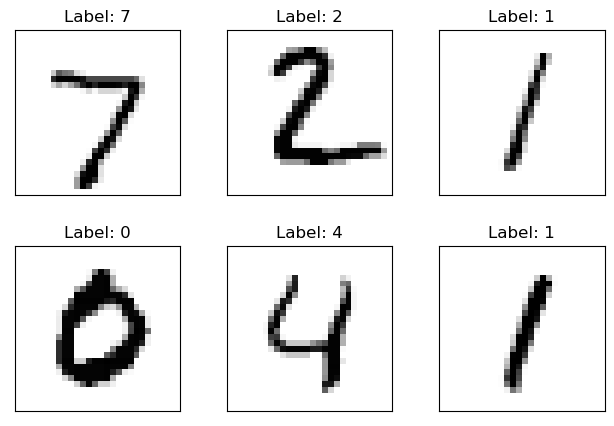

In [3]:
fig = plt.figure()
for i in range(6):
    image, label = test_mnist[i]
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(torchvision.transforms.ToPILImage()(image), cmap="Greys")
    plt.title(f"Label: {label}")
    plt.xticks([])
    plt.yticks([])

# Dataloaders
PyTorch uses dataloaders to load batches of data samples at once. Pretty convenient as we don't have to manually sample dataset instances and then collate them. For heavy datasets, you can set the num_workers argument in the dataloader which uses multiprocessing (Multiprocessing doesn't work in interactive notebooks though, you'll have to run it in a .py file)

In [4]:
train_loader = torch.utils.data.DataLoader(train_mnist,
                                          batch_size=8,
                                          shuffle=True)
small_train_loader = torch.utils.data.DataLoader(small_train_mnist,
                                          batch_size=8,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_mnist,
                                          batch_size=8)
for inputs, labels in train_loader:
    batch_size = inputs.shape[0]
    print(inputs.shape, labels.shape)
    print(inputs.view(batch_size, -1).shape)
    print(labels)
    break

torch.Size([8, 1, 28, 28]) torch.Size([8])
torch.Size([8, 784])
tensor([7, 6, 3, 8, 9, 2, 4, 8])


# Model
Creating the PyTorch model
![image.png](images/mnist_model.png)

In [5]:
class MNISTModel(torch.nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(in_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, out_size)
        
    def forward(self, x):
        x = self.fc1(x) # Equivalent to self.fc1.forward(x)
        x = torch.sigmoid(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        out = self.fc3(x)
        return out

In [6]:
model = MNISTModel(784, 1568, 10)
model.to(device)

MNISTModel(
  (fc1): Linear(in_features=784, out_features=1568, bias=True)
  (fc2): Linear(in_features=1568, out_features=1568, bias=True)
  (fc3): Linear(in_features=1568, out_features=10, bias=True)
)

# Optimizer
Optimizers deal with updating the model using the model's gradients. Adam is one of the most popular ones which makes updates based on exponential moving averages of gradients and their squares. You don't need to worry too much about the theory, but if you're interested you can [read more](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) about it.

In [7]:
# lr is the learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [8]:
# Utility function to evaluate a model using a dataloader. This one calculates accuracy
def test(model, loader):
    # Set the model to eval mode. See line 20 in the next code block for more info
    model.eval()
    
    # torchmetrics is a library that makes accuracy evaluation convenient. You can very easily do it manually as well
    # using only tensor operations
    accuracy = torchmetrics.Accuracy().to(device)
    
    # For each batch in the dataloader...
    for inputs, labels in tqdm(loader, disable=True):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        batch_size = inputs.shape[0]
        
        # Generate predictions. If you're wondering what torch.no_grad() is, it is a context manager that tells pytorch
        # that we don't need to calculate gradients. Saves computation.
        # We can only afford to do this here, not in the training
        # process because, well, we need the gradients there.
        with torch.no_grad():
            predictions = model(inputs.view(batch_size, -1))
        accuracy.update(predictions, labels)
    
    return accuracy.compute()

# The main training loop

In [9]:
# Call this function with argument as number of epochs you want to train the model for
def train(epochs): 
    # Just for plotting later
    train_losses = []
    for epoch in range(epochs):
        for batch_idx, (inputs, labels) in enumerate(pbar := tqdm(train_loader)):
            pbar.set_description(f'Epoch {epoch}')
            
            # Test every 2500 batches. Call the accuracy calculating function for the model with the small_train_loader and
            # test_loader
            if batch_idx % 2500 == 0:
                print(f'After {epoch*7500+batch_idx} batches{" (No training)" * (1 - bool(epoch+batch_idx))}:')
                print(f'Train accuracy = {test(model, small_train_loader):.2%}')
                print(f'Test accuracy = {test(model, test_loader):.2%}')
                print('')
                
                # Set the model to train mode before exiting out of this if condition
                # Read more: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch
                # In actuality, our specific model has no layers that behave differently during training and testing, so this
                # is unnecessary. It's just good practice.
                model.train()
                
            # Send inputs and labels to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Flatten the inputs from shape (batch_size x 1 x 28 x 28) to shape (batch_size x 768)
            # And get model predictions
            batch_size = inputs.shape[0]
            predictions = model(inputs.view(batch_size, -1)) # Recall that this is just model.forward(...)

            # Calculate the loss using labels (Ground truth) and predictions
            loss = torch.nn.functional.cross_entropy(predictions, labels)
            
            # Just for plotting later
            train_losses.append(loss.item())
            
            # Clear out residual model parameter gradients from the previous iteration
            optimizer.zero_grad()

            # Calculate new gradients for this batch
            # ∂L/∂W for all the weights W
            # ∂L/∂b for all the biases b
            loss.backward()

            # Update the model using the gradients and the learning rate α, in essence:
            # W <- W + α * ∂L/∂W for all the weights W
            # b <- b + α * ∂L/∂b for all the biases b
            # But of course, Adam does something slightly more sophisticated as mentioned before
            optimizer.step()
    
    return train_losses

In [10]:
train_losses = train(5)

  0%|          | 0/7500 [00:00<?, ?it/s]

After 0 batches (No training):
Train accuracy = 9.55%
Test accuracy = 9.34%

After 2500 batches:
Train accuracy = 87.17%
Test accuracy = 88.58%

After 5000 batches:
Train accuracy = 89.76%
Test accuracy = 90.76%



  0%|          | 0/7500 [00:00<?, ?it/s]

After 7500 batches:
Train accuracy = 90.81%
Test accuracy = 91.48%

After 10000 batches:
Train accuracy = 92.50%
Test accuracy = 92.98%

After 12500 batches:
Train accuracy = 92.80%
Test accuracy = 93.22%



  0%|          | 0/7500 [00:00<?, ?it/s]

After 15000 batches:
Train accuracy = 93.85%
Test accuracy = 93.85%

After 17500 batches:
Train accuracy = 94.22%
Test accuracy = 94.32%

After 20000 batches:
Train accuracy = 94.24%
Test accuracy = 94.38%



  0%|          | 0/7500 [00:00<?, ?it/s]

After 22500 batches:
Train accuracy = 94.84%
Test accuracy = 94.65%

After 25000 batches:
Train accuracy = 95.13%
Test accuracy = 95.16%

After 27500 batches:
Train accuracy = 95.47%
Test accuracy = 95.46%



  0%|          | 0/7500 [00:00<?, ?it/s]

After 30000 batches:
Train accuracy = 95.92%
Test accuracy = 95.60%

After 32500 batches:
Train accuracy = 95.87%
Test accuracy = 95.71%

After 35000 batches:
Train accuracy = 96.42%
Test accuracy = 95.94%



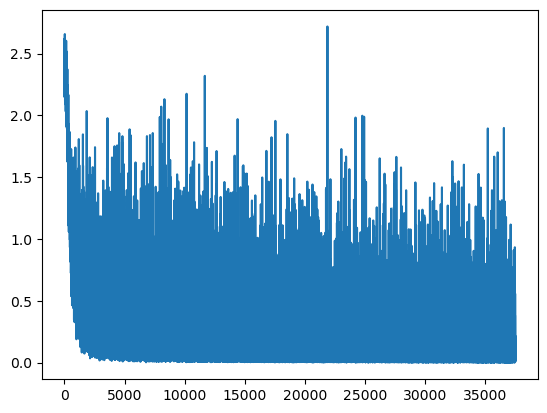

In [11]:
plt.plot(train_losses)

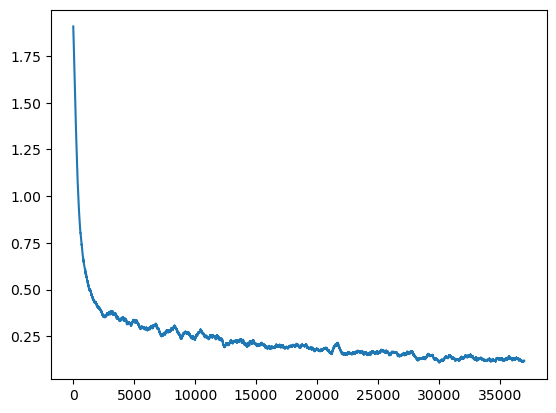

In [12]:
# Plotting moving averages instead of raw noisy losses:
# https://stackoverflow.com/questions/11352047/finding-moving-average-from-data-points-in-python
window_width = 500
cumsum_vec = np.cumsum(np.insert(train_losses, 0, 0)) 
ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
plt.plot(ma_vec)

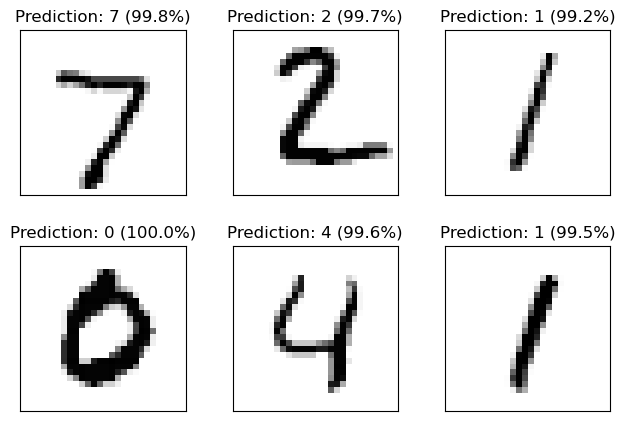

In [13]:
fig = plt.figure()
for i in range(6):
    image, label = test_mnist[i]
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    with torch.no_grad():
        pred = model(image.view(-1).to(device))
    plt.imshow(torchvision.transforms.ToPILImage()(image), cmap="Greys")
    plt.title(f"Prediction: {torch.argmax(pred)} ({torch.max(torch.nn.functional.softmax(pred, dim=0)):.1%})")
    plt.xticks([])
    plt.yticks([])

# The end!